
# 🧠 Black-Scholes-Merton Option Pricing & Greeks
Welcome to **Lightark Finance** – a quant-focused notebook series built from scratch using Python and real-world financial models.

In this first notebook, we’ll implement the **Black-Scholes-Merton (BSM)** model to price European **Call and Put Options**, and compute the **Option Greeks** (Delta, Gamma, Vega, Theta, Rho) which are crucial for understanding risk and sensitivity in trading strategies.

We'll also show how to:
- Calculate option prices using the BSM formula
- Estimate sensitivities using Greeks
- Lay the groundwork for future projects like Monte Carlo Simulations and Portfolio Optimization

---


## 📦 Import Required Libraries

In [1]:

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


## 💹 Black-Scholes-Merton Option Pricing Model


The BSM model assumes a lognormal distribution for the asset price and provides a closed-form solution for European call and put options.

The formulas are:

- Call Option Price: $C_0 = S_0e^{-qt}N(d_1)-Xe^{-rt}N(d_2)$
- Put Option Price: $P_0 = Xe^{-rt}N(-d_2)- S_0e^{-qt}N(-d_1)$

Where:
- $S_0 =$ Underlying Price
- $X =$ Exercise/Strike Price
- $\sigma  =$ Volatility (% p.a.)
- $r =$ Continuously compounded Risk-Free Interest Rate (% p.a.)
- $t =$ Time to Expiration (in Years)
- $N(x) =$ Standard Normal Cumulative Distributive Function
- $q =$ Continuously Compounded Dividend Yield (% p.a.)
- $d_1 = \frac{ln\left ( \frac{S_0}{X} \right )+(r-q+\frac{1}{2}\sigma^2)t}{\sigma \sqrt t}$
- $d_2=d_1- \sigma \sqrt t$


In [2]:
def bsm_option_price(S, X, sigma, r, q, t, option_type='call'):
    T = t/365
    d1 = (math.log(S / X) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    if option_type == 'call':
        price = S * math.exp(-q * T) * norm.cdf(d1) - X * math.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = X * math.exp(-r * T) * norm.cdf(-d2) - S * math.exp(-q * T) * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    return price


In [3]:
# Sample test
S = 50       # Underlying Price
X = 52       # Exercise/Strike Price
sigma = 0.25 # Volatility (as a decimal)
r = 0.03     # Risk-free rate (as a decimal)
q = 0.00     # Dividend yield (as a decimal)
t = 2        # Time to maturity (in Days)
Option_Type = 'put' # Option Type (call/put)

bsm_option_price(S, X, sigma, r, q, t, Option_Type)


1.9973811412797318


## 📐 Option Greeks – Sensitivity Analysis

Option Greeks are used to measure different dimensions of risk involved in taking an options position.

We'll implement:

- **Delta (Call & Put)**: Sensitivity to underlying asset price
- **Gamma**: Sensitivity of delta to the underlying asset price
- **Theta (Call & Put)**: Sensitivity to time decay
- **Vega**: Sensitivity to volatility
- **Rho (Call & Put)**: Sensitivity to interest rates


In [4]:

def bsm_greeks(S, X, sigma, r, q, t):
    T = t / 365
    d1 = (math.log(S / X) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    delta_call = math.exp(-q * T) * norm.cdf(d1)
    delta_put = math.exp(-q * T) * (norm.cdf(d1) - 1)

    gamma = math.exp(-q * T)/(S*sigma*math.sqrt(T)) * math.exp(-0.5 * d1 ** 2) / math.sqrt(2 * math.pi) 

    theta_call = 1/365 * ((-S * sigma * math.exp(-q * T) * math.exp(-0.5 * d1 ** 2) / (2 * math.sqrt(T)) - r* X * math.exp(-r * T) * norm.cdf(d2) + q * S * math.exp(-q * T) * norm.cdf(d1)))

    theta_put = 1/365 * ((-S * sigma * math.exp(-q * T) * math.exp(-0.5 * d1 ** 2) / (2 * math.sqrt(T)) + r* X * math.exp(-r * T) * norm.cdf(-d2) - q * S * math.exp(-q * T) * norm.cdf(-d1)))

    vega = 1/100 * S * math.exp(-q * T) * math.sqrt(T) * math.exp(-0.5 * d1 ** 2) / math.sqrt(2 * math.pi)

    rho_call = 1/100 * X * T * math.exp(-r * T) * norm.cdf(d2)
    rho_put = -1/100 * X * T * math.exp(-r * T) * norm.cdf(-d2)

    return {
        'Delta (Call)': delta_call,
        'Delta (Put)': delta_put,
        'Gamma': gamma,
        'Vega': vega,
        'Theta (Call)': theta_call,
        'Theta (Put)': theta_put,
        'Rho (Call)': rho_call,
        'Rho (Put)': rho_put
    }


In [5]:

# Sample test
S = 305       # Underlying Price
X = 335       # Exercise/Strike Price
sigma = 0.25 # Volatility (as a decimal)
r = 0.03     # Risk-free rate (as a decimal)
q = 0.00     # Dividend yield (as a decimal)
t = 182        # Time to maturity (in Days)

greeks = bsm_greeks(S, X, sigma, r, q, t)
for k, v in greeks.items():
    print(f"{k}: {v:.4f}")


Delta (Call): 0.3600
Delta (Put): -0.6400
Gamma: 0.0069
Vega: 0.8057
Theta (Call): -0.1468
Theta (Put): -0.1196
Rho (Call): 0.4876
Rho (Put): -1.1580


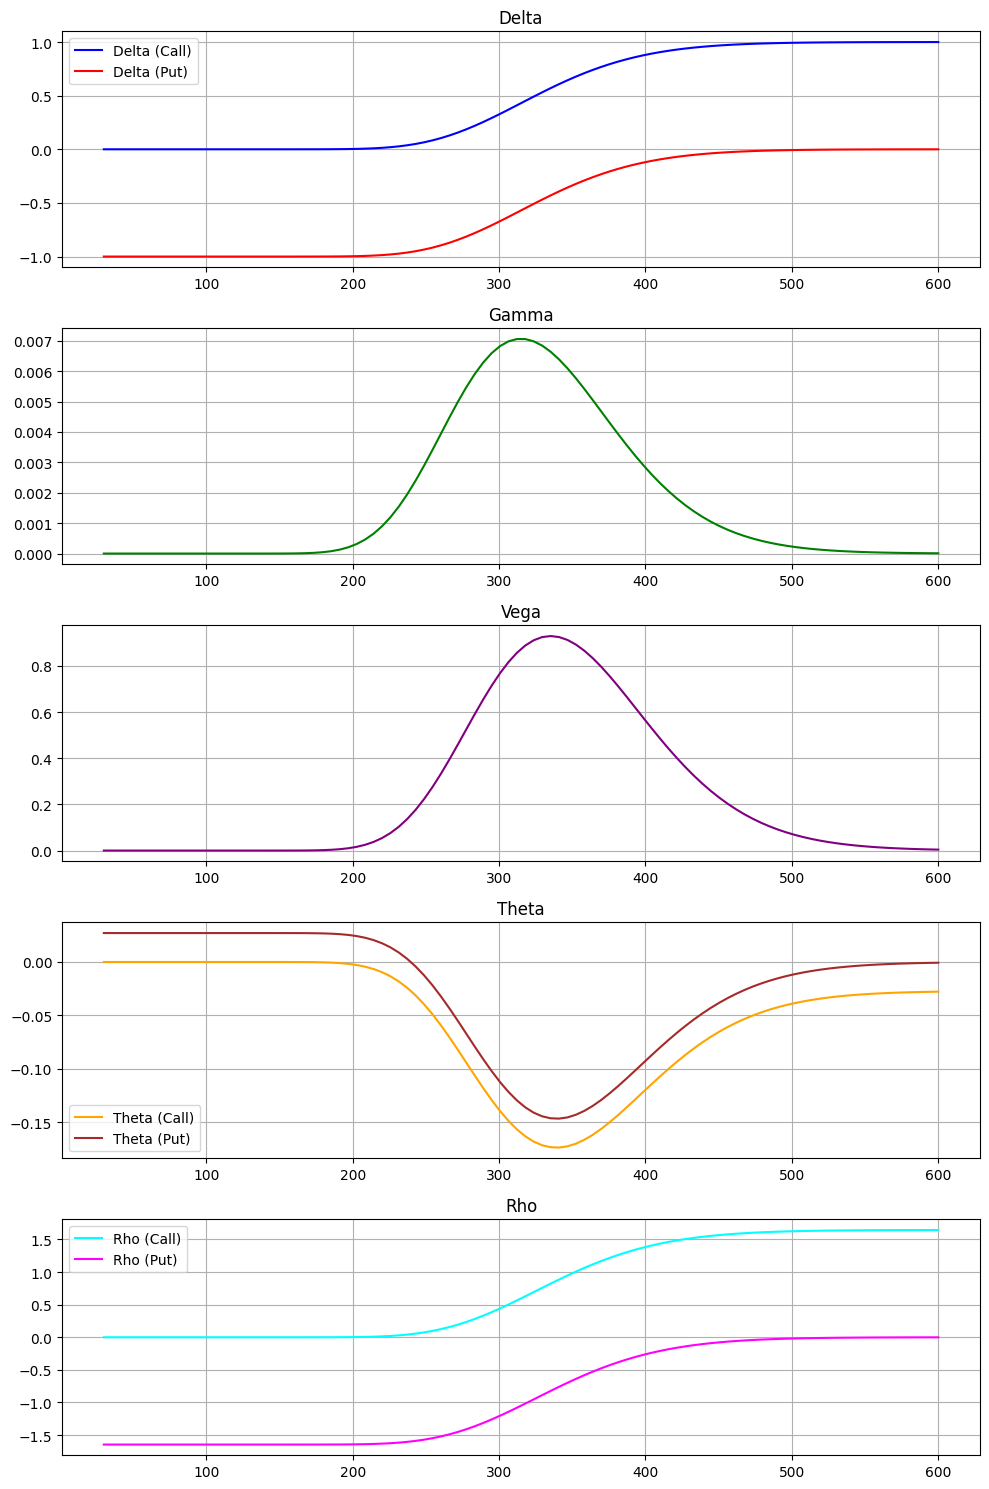

In [6]:
def plot_all_greeks(S_range, X, sigma, r, q, t):
    """
    Plot all Greeks in a single figure with subplots.
    Fixes infinite plotting issue and improves clarity.
    """
    plt.close('all')  # Prevents overlapping/duplicate plots
    
    # Initialize lists
    deltas_call, deltas_put = [], []
    gammas, vegas = [], []
    thetas_call, thetas_put = [], []
    rhos_call, rhos_put = [], []
    
    for S in S_range:
        greeks = bsm_greeks(S, X, sigma, r, q, t)
        deltas_call.append(greeks['Delta (Call)'])
        deltas_put.append(greeks['Delta (Put)'])
        gammas.append(greeks['Gamma'])
        vegas.append(greeks['Vega'])
        thetas_call.append(greeks['Theta (Call)'])
        thetas_put.append(greeks['Theta (Put)'])
        rhos_call.append(greeks['Rho (Call)'])
        rhos_put.append(greeks['Rho (Put)'])
    
    # Create figure with 5 subplots (one per Greek)
    fig, axes = plt.subplots(5, 1, figsize=(10, 15))
    
    # Delta
    axes[0].plot(S_range, deltas_call, label='Delta (Call)', color='blue')
    axes[0].plot(S_range, deltas_put, label='Delta (Put)', color='red')
    axes[0].set_title("Delta")
    axes[0].legend()
    axes[0].grid()
    
    # Gamma
    axes[1].plot(S_range, gammas, label='Gamma', color='green')
    axes[1].set_title("Gamma")
    axes[1].grid()
    
    # Vega
    axes[2].plot(S_range, vegas, label='Vega', color='purple')
    axes[2].set_title("Vega")
    axes[2].grid()
    
    # Theta
    axes[3].plot(S_range, thetas_call, label='Theta (Call)', color='orange')
    axes[3].plot(S_range, thetas_put, label='Theta (Put)', color='brown')
    axes[3].set_title("Theta")
    axes[3].legend()
    axes[3].grid()
    
    # Rho
    axes[4].plot(S_range, rhos_call, label='Rho (Call)', color='cyan')
    axes[4].plot(S_range, rhos_put, label='Rho (Put)', color='magenta')
    axes[4].set_title("Rho")
    axes[4].legend()
    axes[4].grid()
    
    plt.tight_layout()
    plt.savefig('all_greeks.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
S_range = np.linspace(30, 600, 100)
plot_all_greeks(S_range, X=335, sigma=0.25, r=0.03, q=0.00, t=182)